# 2019 Fantasy Football Projections based on 2009-18 statistics.

### Importing Packages

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from xgboost import XGBRegressor
from sklearn.feature_selection import RFE
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt

In [2]:
import warnings
warnings.filterwarnings("ignore")

### Loading Data

In [3]:
relevant_columns_stats = ["Season", "playerID", "game.id", "Team", "name", "pass.att", "pass.comp",
                    "passyds", "pass.tds", "pass.ints", "rush.att", "rushyds",
                    "rushtds", "recyds", "rec.tds", "recept", "kickret.avg",
                   "kickret.tds", "kick.rets", "punt.rets", "puntret.avg", 
                   "puntret.tds", "fgm", "fga", "fgyds", "xpmade", "xpmissed",
                   "sacks", 'defints', "forced.fumbs", "totalfumbs", "recfumbs", "pass.twoptm",
                   "fumbslost", "rec.twoptm", "rush.twoptm"]


df_train = pd.read_csv("2009stats.csv", usecols = relevant_columns_stats)
df_train = df_train.append(pd.read_csv("2010stats.csv", usecols = relevant_columns_stats))
df_train = df_train.append(pd.read_csv("2011stats.csv", usecols = relevant_columns_stats))
df_train = df_train.append(pd.read_csv("2012stats.csv", usecols = relevant_columns_stats))
df_train = df_train.append(pd.read_csv("2013stats.csv", usecols = relevant_columns_stats))
df_train = df_train.append(pd.read_csv("2014stats.csv", usecols = relevant_columns_stats))
df_train = df_train.append(pd.read_csv("2015stats.csv", usecols = relevant_columns_stats))
df_train = df_train.append(pd.read_csv("2016stats.csv", usecols = relevant_columns_stats))
df_train = df_train.append(pd.read_csv("2017stats.csv", usecols = relevant_columns_stats))
df_train = df_train.append(pd.read_csv("2018stats.csv", usecols = relevant_columns_stats))
df_train.Team = df_train.Team.replace("STL","LA")
df_train.Team = df_train.Team.replace("SD","LAC")
df_train.Team = df_train.Team.replace("JAC","JAX")


df_train.dropna(inplace = True)

relevant_columns_def = ["Tm","PR TD","KR TD","FblTD","IntTD","OthTD","Sfty"]

relevant_columns_def = ["Tm","PR TD","KR TD","FblTD","IntTD","OthTD","Sfty"]

df_def = pd.read_csv("2009def.csv", usecols = relevant_columns_def)
df_def = df_def.append(pd.read_csv("2010def.csv", usecols = relevant_columns_def))
df_def = df_def.append(pd.read_csv("2011def.csv", usecols = relevant_columns_def))
df_def = df_def.append(pd.read_csv("2012def.csv", usecols = relevant_columns_def))
df_def = df_def.append(pd.read_csv("2013def.csv", usecols = relevant_columns_def))
df_def = df_def.append(pd.read_csv("2014def.csv", usecols = relevant_columns_def))
df_def = df_def.append(pd.read_csv("2015def.csv", usecols = relevant_columns_def))
df_def = df_def.append(pd.read_csv("2016def.csv", usecols = relevant_columns_def))
df_def = df_def.append(pd.read_csv("2017def.csv", usecols = relevant_columns_def))
df_def = df_def.append(pd.read_csv("2018def.csv", usecols = relevant_columns_def))

### Adding Attributes for Opposition and Making Way to Merge Data Sets

In [4]:
df_def["sum_vals"] = 1

df_abbreviations = pd.read_csv("abbreviations.csv")

df_def = df_def.merge(df_abbreviations, on = ["Tm"])


df_def["Season"] = df_def.groupby("Team")["sum_vals"].transform(lambda x: x.cumsum() + 2008)

df_def.fillna(0, inplace = True)

df_def.drop(["Tm", "sum_vals"], inplace = True, axis = 1)

df_train['opp'] = df_train.groupby("game.id").Team.transform(lambda x: x.unique()[0])
df_train['opp2'] = df_train.groupby("game.id").Team.transform(lambda x: x.unique()[1])

df_train.loc[df_train['opp'] == df_train['Team'], 'opp'] = df_train.loc[df_train['opp'] == df_train['Team'], 'opp2']
df_train.drop(['opp2'], axis = 1, inplace = True)

## Loading Position

In [5]:
relevant_columns_pos = ["GSIS_ID", "Season", "Pos"]

df_pos = pd.read_csv("2009Pos.csv", usecols = relevant_columns_pos)
df_pos = df_pos.append(pd.read_csv("2010Pos.csv", usecols = relevant_columns_pos))
df_pos = df_pos.append(pd.read_csv("2011Pos.csv", usecols = relevant_columns_pos))
df_pos = df_pos.append(pd.read_csv("2012Pos.csv", usecols = relevant_columns_pos))
df_pos = df_pos.append(pd.read_csv("2013Pos.csv", usecols = relevant_columns_pos))
df_pos = df_pos.append(pd.read_csv("2014Pos.csv", usecols = relevant_columns_pos))
df_pos = df_pos.append(pd.read_csv("2015Pos.csv", usecols = relevant_columns_pos))
df_pos = df_pos.append(pd.read_csv("2016Pos.csv", usecols = relevant_columns_pos))
df_pos = df_pos.append(pd.read_csv("2017Pos.csv", usecols = relevant_columns_pos))
df_pos = df_pos.append(pd.read_csv("2018Pos.csv", usecols = relevant_columns_pos))

df_pos.Pos = df_pos.Pos.replace("FB","RB")

### Separating Data into Offense and Defense

In [6]:
def_columns = ["Team","rec.twoptm",
              "passyds", "pass.tds", "rushyds",
              "rushtds", "kickret.tds", "puntret.tds", "fgm",
              "xpmade", "fumbslost", "pass.ints",
              "rush.twoptm"]

df_defense = df_train

df_defense["points_allowed"] = ((df_defense["pass.tds"] + df_defense["rushtds"] + df_defense["kickret.tds"]
                                 + df_defense["puntret.tds"]) * 6 + df_defense["fgm"] * 3 +
                                df_defense["rec.twoptm"] * 2 + df_defense["rush.twoptm"] * 2
                                + df_defense["xpmade"])

df_defense["yards"] = df_defense["passyds"] + df_defense["rushyds"]

df_defense = df_defense.groupby(["game.id","opp", "Season",])["yards", "points_allowed"].sum().reset_index()

In [7]:
df_defense["0pts"] = df_defense.points_allowed == 0
df_defense["1_6pts"] = df_defense.points_allowed.between(1, 6)
df_defense["7_13pts"] = df_defense.points_allowed.between(7, 13)
df_defense["14_17pts"] = df_defense.points_allowed.between(14, 17)
df_defense["18_27pts"] = df_defense.points_allowed.between(18, 27)
df_defense["28_34pts"] = df_defense.points_allowed.between(28, 34)
df_defense["35_45pts"] = df_defense.points_allowed.between(35, 45)
df_defense["45pts"] = df_defense.points_allowed > 45

df_defense["YA100"] = df_defense.yards < 100
df_defense["YA199"] = df_defense.yards.between(100, 199)
df_defense["YA299"] = df_defense.yards.between(200, 299)
df_defense["YA349"] = df_defense.yards.between(300, 349)
df_defense["YA399"] = df_defense.yards.between(350, 399)
df_defense["YA449"] = df_defense.yards.between(400, 449)
df_defense["YA499"] = df_defense.yards.between(450, 499)
df_defense["YA549"] = df_defense.yards.between(500, 549)
df_defense["YA550"] = df_defense.yards > 549

In [8]:
def_columns = ["0pts", "1_6pts", "7_13pts", "14_17pts",
               "28_34pts","35_45pts","45pts",
               "YA100","YA199","YA299","YA399",
               "YA449","YA499","YA549","YA550", "YA349", "18_27pts"]


df_defense = df_defense.groupby(["Season", "opp"])[def_columns].sum()



df_defense["Sacks"] = df_train.groupby(["Season", "Team"])["sacks"].sum()

df_train["exp"] = df_train.groupby("playerID").Season.transform(lambda x: x - min(x))

df_defense["exp"] = df_train.groupby(["Season", "Team"])["exp"].mean()

df_train.drop("exp", inplace = True, axis = 1)

df_defense["pass.ints"] = df_train.groupby(["Season", "opp"])["pass.ints"].sum()

df_defense["fumbslost"] = df_train.groupby(["Season", "opp"])["fumbslost"].sum()

df_defense["rush_per_att"] = (df_train.groupby(["Season", "opp"])["rushyds"].sum() / 
                                df_train.groupby(["Season", "opp"])["rush.att"].sum())

df_defense["td_rush_per_att"] = (df_train.groupby(["Season", "opp"])["rushtds"].sum() / 
                                df_train.groupby(["Season", "opp"])["rush.att"].sum())

df_defense["rec_per_att"] = (df_train.groupby(["Season", "opp"])["recyds"].sum() / 
                                df_train.groupby(["Season", "opp"])["recept"].sum())

df_defense["td_rec_per_att"] = (df_train.groupby(["Season", "opp"])["rec.tds"].sum() / 
                                df_train.groupby(["Season", "opp"])["recept"].sum())

df_defense["pass_per_att"] = (df_train.groupby(["Season", "opp"])["passyds"].sum() / 
                                df_train.groupby(["Season", "opp"])["pass.att"].sum())

df_defense["td_pass_per_att"] = (df_train.groupby(["Season", "opp"])["pass.tds"].sum() / 
                                df_train.groupby(["Season", "opp"])["pass.att"].sum())

df_defense["pass_per_comp"] = (df_train.groupby(["Season", "opp"])["passyds"].sum() / 
                                df_train.groupby(["Season", "opp"])["pass.comp"].sum())

df_defense["td_pass_per_comp"] = (df_train.groupby(["Season", "opp"])["pass.tds"].sum() / 
                                df_train.groupby(["Season", "opp"])["pass.comp"].sum())



df_defense = df_defense.merge(df_def, left_on = ["opp", "Season"], right_on = ["Team", "Season"])

df_defense["TD"] = (df_defense["PR TD"] + df_defense["KR TD"] + df_defense["FblTD"] + df_defense["IntTD"] +
+df_defense["OthTD"])

df_defense["turnovers"] = df_defense["fumbslost"] + df_defense["pass.ints"]

df_defense.drop(["fumbslost", "pass.ints", 
            "PR TD","KR TD","FblTD","IntTD","OthTD"], axis = 1, inplace = True)


df_defense_scores = (df_defense["TD"]*6 + df_defense["turnovers"] * 2 + df_defense["Sacks"] + df_defense["Sfty"] * 2 +
                    (df_defense["0pts"] + df_defense["YA100"]) * 5 + 
                    df_defense['1_6pts'] * 4 +
                    (df_defense["7_13pts"] + df_defense["YA199"]) * 3 +
                     df_defense["YA299"] * 2 +
                    df_defense["14_17pts"] +
                    (df_defense["YA399"] + df_defense["28_34pts"]) * (-1) +
                    (df_defense["YA449"] + df_defense["35_45pts"]) * (-3) +
                    (df_defense["YA499"] + df_defense["45pts"]) * (-5) +
                    (df_defense["YA549"]) * (-6) +
                    (df_defense["YA550"]) * (-7)).to_frame()

off_columns = ["Season", "playerID", "game.id", "Team", "name", "pass.att", "pass.comp",
                    "passyds", "pass.tds", "pass.ints", "rush.att", "rushyds",
                    "rushtds", "recyds", "rec.tds", "recept", "kickret.avg",
                   "kickret.tds", "kick.rets", "punt.rets", "puntret.avg", 
                   "puntret.tds", "fumbslost", "rec.twoptm", "rush.twoptm", "pass.twoptm",
              "fgm", "fga", "fgyds", "xpmade", "xpmissed", "totalfumbs", "opp"]

off_columns_numeric = ["pass.att", "pass.comp", "totalfumbs", "fumbslost",
                    "passyds", "pass.tds", "pass.ints", "rush.att", "rushyds",
                    "rushtds", "recyds", "rec.tds", "recept", "kickret.avg",
                   "kickret.tds", "kick.rets", "punt.rets", "puntret.avg", 
                   "puntret.tds", "rec.twoptm", "rush.twoptm", "pass.twoptm",
                      "fgm", "fga", "fgyds", "xpmade", "xpmissed"]



df_offense = df_train[off_columns]


df_offense = pd.merge(df_offense, df_pos, left_on = ["playerID", "Season"], 
                      right_on = ["GSIS_ID", "Season"], how = "left").drop("GSIS_ID", axis = 1)

df_offense.Pos = df_offense.groupby("playerID").Pos.fillna(method = 'ffill')
df_offense.Pos = df_offense.groupby("playerID").Pos.fillna(method = 'bfill')

df_offense = df_offense.dropna(subset = ["Pos"])



df_offense['n_games'] = df_offense.groupby(['playerID', 'Season'])['game.id'].transform(lambda x: len(x.unique()))


df_offense["points"] = (df_offense["passyds"] * 0.025 + 4 * df_offense["pass.tds"] - 2 * df_offense["pass.ints"]
                       + 0.1 * df_offense["rushyds"] + 6 * df_offense["rushtds"] + 0.1 * df_offense["recyds"] +
                        6 * df_offense["rec.tds"] + 6 * df_offense["kickret.tds"] + 6 * df_offense["puntret.tds"]
                       + 2 * df_offense["rec.twoptm"] + 2 * df_offense["rush.twoptm"] + 2 * df_offense["pass.twoptm"]
                       + 4 * df_offense["fgm"] - df_offense["fga"] + 
                        df_offense["xpmade"] - 2 * df_offense["fumbslost"])

off_columns_numeric.append('points')

off_columns_numeric_no_avg = off_columns_numeric.copy()


for col in off_columns_numeric_no_avg:    
    df_offense[col + '_per_game'] = df_offense[col] / df_offense['n_games']
    
    df_offense[col + '_var'] = ((df_offense[col] - 
                                 df_offense.groupby(["Season", "playerID"])[col + '_per_game'].transform(lambda x: sum(x))
                                ) ** 2/df_offense['n_games'])
    
    df_offense[col + '_var'] = ((df_offense[col] - 
                                 df_offense.groupby(["playerID"])[col + '_per_game'].transform(lambda x: sum(x))
                                ) ** 2/df_offense['n_games'])
    
    off_columns_numeric.append(col + '_per_game')
    
    off_columns_numeric.append(col + '_var')

off_columns_numeric.append('n_games')



df_offense.Team = df_offense.groupby(["Season", "playerID"]).Team.transform(lambda x: x.iloc[len(x) - 1])

df_offense = pd.merge(df_offense.groupby(["Season", "playerID", "Team"])[off_columns_numeric].sum().reset_index(),
                      df_offense[["playerID", "name"]].drop_duplicates("playerID", keep = "last"), on = "playerID")


df_offense['n_games'] = np.sqrt(df_offense['n_games'])

df_offense["points"] = (df_offense["passyds"] * 0.025 + 4 * df_offense["pass.tds"] - 2 * df_offense["pass.ints"]
                       + 0.1 * df_offense["rushyds"] + 6 * df_offense["rushtds"] + 0.1 * df_offense["recyds"] +
                        6 * df_offense["rec.tds"] + 6 * df_offense["kickret.tds"] + 6 * df_offense["puntret.tds"]
                       + 2 * df_offense["rec.twoptm"] + 2 * df_offense["rush.twoptm"] + 2 * df_offense["pass.twoptm"]
                       + 4 * df_offense["fgm"] - df_offense["fga"] + 
                        df_offense["xpmade"] - 2 * df_offense["fumbslost"])



df_offense['total_games'] = df_offense.groupby(["playerID"])['n_games'].transform(lambda x: np.cumsum(x))

off_columns_numeric.append('total_games')

for col in off_columns_numeric_no_avg:
    df_offense[col + "_career"] = df_offense.groupby(["playerID"])[col].transform(lambda x: np.cumsum(x))
    
    df_offense[col + "_career_per_game"] = df_offense.groupby(["playerID"])[col].transform(lambda x: 
                                                                                           np.cumsum(x))/df_offense['total_games']

    off_columns_numeric.append(col + "_career")
    
    off_columns_numeric.append(col + "_career_per_game")

In [9]:
df_offense['rush_per_att'] = (df_offense['rushyds'] / df_offense['rush.att']).fillna(0)
df_offense['rush_per_att'].loc[df_offense['rush_per_att'] == np.inf] = 0
off_columns_numeric.append('rush_per_att')

df_offense['pass_per_att'] = (df_offense['passyds'] / df_offense['pass.att']).fillna(0)
df_offense['pass_per_att'].loc[df_offense['pass_per_att'] == np.inf] = 0
off_columns_numeric.append('pass_per_att')


df_offense['pass_per_comp'] = (df_offense['passyds'] / df_offense['pass.comp']).fillna(0)
df_offense['pass_per_comp'].loc[df_offense['pass_per_comp'] == np.inf] = 0
off_columns_numeric.append('pass_per_comp')


df_offense['rec_per_att'] = (df_offense['recyds'] / df_offense['recept']).fillna(0)
df_offense['rec_per_att'].loc[df_offense['rec_per_att'] == np.inf] = 0
off_columns_numeric.append('rec_per_att')

df_offense['td_rush_per_att'] = (df_offense['rushtds'] / df_offense['rush.att']).fillna(0)
df_offense['td_rush_per_att'].loc[df_offense['td_rush_per_att'] == np.inf] = 0
off_columns_numeric.append('td_rush_per_att')

df_offense['td_pass_per_att'] = (df_offense['pass.tds'] / df_offense['pass.att']).fillna(0)
df_offense['td_pass_per_att'].loc[df_offense['td_pass_per_att'] == np.inf] = 0
off_columns_numeric.append('td_pass_per_att')


df_offense['td_pass_per_comp'] = (df_offense['pass.tds'] / df_offense['pass.comp']).fillna(0)
df_offense['td_pass_per_comp'].loc[df_offense['td_pass_per_comp'] == np.inf] = 0
off_columns_numeric.append('td_pass_per_comp')


df_offense['td_rec_per_att'] = (df_offense['rec.tds'] / df_offense['recept']).fillna(0)
df_offense['td_rec_per_att'].loc[df_offense['td_rec_per_att'] == np.inf] = 0
off_columns_numeric.append('td_rec_per_att')


df_offense['fumb_rush_per_att'] = (df_offense['totalfumbs'] / df_offense['rush.att']).fillna(0)
df_offense['fumb_rush_per_att'].loc[df_offense['fumb_rush_per_att'] == np.inf] = 0
off_columns_numeric.append('fumb_rush_per_att')

df_offense['fumb_pass_per_att'] = (df_offense['totalfumbs'] / df_offense['pass.att']).fillna(0)
df_offense['fumb_pass_per_att'].loc[df_offense['fumb_pass_per_att'] == np.inf] = 0
off_columns_numeric.append('fumb_pass_per_att')

df_offense['int_pass_per_att'] = (df_offense['pass.ints'] / df_offense['pass.att']).fillna(0)
df_offense['int_pass_per_att'].loc[df_offense['int_pass_per_att'] == np.inf] = 0
off_columns_numeric.append('int_pass_per_att')

df_offense['fumb_per_rec'] = (df_offense['totalfumbs'] / df_offense['recept']).fillna(0)
df_offense['fumb_per_rec'].loc[df_offense['fumb_per_rec'] == np.inf] = 0
off_columns_numeric.append('fumb_per_rec')

### Adding data for previous data

In [10]:
df_offense = pd.merge(df_offense, df_pos, left_on = ["playerID", "Season"], 
                      right_on = ["GSIS_ID", "Season"], how = "left").drop("GSIS_ID", axis = 1)

df_offense.Pos = df_offense.groupby("playerID").Pos.fillna(method = 'ffill')
df_offense.Pos = df_offense.groupby("playerID").Pos.fillna(method = 'bfill')

relevant_prev_columns = off_columns_numeric.copy()

relevant_columns_spotrac = ['PLAYER', 'POS', 'TEAM']

df_spotrac = pd.read_csv("Spotrac_NFLActivePlayerContracts.csv", encoding = "ISO-8859-1",
                        usecols = relevant_columns_spotrac)

df_spotrac = df_spotrac.loc[df_spotrac.POS != 'OLB']
df_spotrac = df_spotrac.loc[df_spotrac.POS != 'DT']
df_spotrac = df_spotrac.loc[df_spotrac.POS != 'DE']
df_spotrac = df_spotrac.loc[df_spotrac.POS != 'LT']
df_spotrac = df_spotrac.loc[df_spotrac.POS != 'ILB']
df_spotrac = df_spotrac.loc[df_spotrac.POS != 'G']
df_spotrac = df_spotrac.loc[df_spotrac.POS != 'FS']
df_spotrac = df_spotrac.loc[df_spotrac.POS != 'CB']
df_spotrac = df_spotrac.loc[df_spotrac.POS != 'RT']
df_spotrac = df_spotrac.loc[df_spotrac.POS != 'SS']
df_spotrac = df_spotrac.loc[df_spotrac.POS != 'C']
df_spotrac = df_spotrac.loc[df_spotrac.POS != 'P']
df_spotrac = df_spotrac.loc[df_spotrac.POS != 'LB']
df_spotrac = df_spotrac.loc[df_spotrac.POS != 'T']
df_spotrac = df_spotrac.loc[df_spotrac.POS != 'S']
df_spotrac = df_spotrac.loc[df_spotrac.POS != 'LS']

df_spotrac.PLAYER = df_spotrac.PLAYER.transform(lambda x: x.str.split('\xa0').str.get(0))
df_spotrac.PLAYER = df_spotrac.PLAYER.transform(lambda x: x.str.split(' ').str.get(0).str[0] + '.' + 
                                         x.str.split(' ').str.get(-1))

df_spotrac.TEAM = df_spotrac.TEAM.transform(lambda x: x.str.split('Signed').str.get(0))
df_spotrac.rename(columns={"PLAYER": "name", "TEAM": "next_Team", "POS": "Pos"}, inplace = True)

df_spotrac.loc[df_spotrac.name == "O.Jr.", "name"] = "O.Beckham"
df_spotrac.loc[df_spotrac.name == "T.Jr.", "name"] = "T.Ginn"

df_spotrac["name_dict"] = df_spotrac["name"] + "_" + df_spotrac["Pos"]

df_offense.sort_values(["Season", "Team"], inplace = True)
df_offense.reset_index(inplace = True, drop = True)

df_offense["name_dict"] = df_offense["name"] + "_" + df_offense["Pos"]

df_offense["next_Team"] = df_offense.groupby("playerID").Team.transform(lambda x: x.shift(-1))
df_offense["prev_Team"] = df_offense.groupby("playerID").Team.transform(lambda x: x.shift())
df_offense.next_Team = df_offense.set_index("name_dict").next_Team.fillna(
    df_spotrac.reindex(index=df_spotrac.index[::-1]).set_index("name_dict").to_dict()["next_Team"]).tolist()

df_offense["next_Season"] = df_offense.Season + 1

df_offense_2019 = df_offense.loc[df_offense.Season == 2018]

df_offense_2019[list(set(df_offense_2019.columns) - set(["Season", "playerID", "Team", "name", "next_Team", "Pos"]))] = np.nan
df_offense_2019["Season"] = df_offense_2019["Season"] + 1
df_offense_2019["prev_Team"] = df_offense_2019["Team"]
df_offense_2019["Team"] = df_offense_2019["next_Team"]

df_offense = df_offense.append(df_offense_2019)
#df_offense = df_offense.dropna(axis = 0)

df_total_offense = df_offense.groupby(["next_Season", "next_Team"])[relevant_prev_columns].apply(lambda x: x.sum()).reset_index()

off_columns_numeric.append('playerID')
off_columns_numeric.append('next_Season')

player_prev_merge_cols = off_columns_numeric

In [11]:
relevant_columns_sched2019 = ["Week", "VisTm", "HomeTm"]

df_sched2019 = pd.read_csv("profootballref_schedule.csv", usecols = relevant_columns_sched2019)
df_sched2019 = df_sched2019.loc[~df_sched2019.Week.str.contains("Pre")]

In [12]:
df_sched2019 = pd.merge(pd.merge(df_sched2019, df_abbreviations, left_on = "VisTm", right_on = "Tm").drop(["VisTm", "Tm"],
                                                                                                          axis = 1),
         df_abbreviations,
        left_on = "HomeTm",
        right_on = "Tm")[["Team_x", "Team_y"]]

df_sched2019 = df_sched2019.append(df_sched2019.rename({"Team_x": "Team_y", "Team_y": "Team_x"}))

df_sched2019.rename({"Team_x": "opp", "Team_y": "Team"})

df_sched2019.columns = ["opp", "Team"]

df_sched2019["Season"] = 2019

In [13]:
df_offense = pd.merge(df_offense, df_offense[player_prev_merge_cols], left_on = ["playerID", "Season"],
                      right_on = ["playerID", "next_Season"],
                     suffixes = ["", "_player_prev"])

df_offense = pd.merge(df_offense, df_total_offense, left_on = ["Team", "Season"], right_on = ["next_Team", "next_Season"],
                     suffixes = ["", "_new_Team_prev"])

df_offense = pd.merge(df_offense, df_total_offense, left_on = ["prev_Team", "Season"], right_on = ["next_Team", "next_Season"],
                     suffixes = ["", "_old_Team_prev"])

for col in relevant_prev_columns:
    df_offense[col + "_Team_prev_delta"] = df_offense[col + "_new_Team_prev"] - df_offense[col + "_old_Team_prev"]
    
    
df_offense["exp"] = df_offense.groupby("playerID").Season.transform(lambda x: x - min(x))


relevant_sched_columns  = off_columns_numeric_no_avg.copy()
relevant_sched_columns.remove('points')


df_sched = df_train.groupby(["Season", "opp"])[["Team", "game.id"]].apply(lambda x: x.drop_duplicates("game.id")).reset_index().drop(["level_2", "game.id"], axis = 1)

df_prevSched =  pd.merge(df_sched,
         (df_train.groupby(["Season", "Team"])[relevant_sched_columns].sum()/16).reset_index(),
        left_on = ["Season", "opp"], right_on = ["Season", "Team"]).groupby(["opp","Season"]).sum().reset_index()
 
df_prevSched["Season"] += 1    

df_sched = df_sched.append(df_sched2019)

df_sched.Season -= 1

df_currSched =  pd.merge(df_sched,
         (df_train.groupby(["Season", "Team"])[relevant_sched_columns].sum()/16).reset_index(),
        left_on = ["Season", "opp"], right_on = ["Season", "Team"]).groupby(["opp","Season"]).sum().reset_index()
 
df_currSched["Season"] += 1     

df_offense = pd.merge(df_offense,
                      df_prevSched,
         left_on = ["Team", "Season"],
         right_on = ["opp", "Season"],
         suffixes = ["", "_curr_sched"])
    
    
df_offense = pd.merge(df_offense, 
        df_currSched,
         left_on = ["prev_Team", "Season"],
         right_on = ["opp", "Season"],
         suffixes = ["", "_past_sched"])

df_defense = pd.merge(df_defense,
                     df_currSched,
         left_on = ["Team", "Season"],
         right_on = ["opp", "Season"],
         suffixes = ["", "_curr_sched"])

df_defense = pd.merge(df_defense,
                     df_prevSched,
         left_on = ["Team", "Season"],
         right_on = ["opp", "Season"],
         suffixes = ["", "_past_sched"])

for col in list(set(relevant_sched_columns) - set(["Team"])):
    df_offense[col + "_delta_sched"] = df_offense[col + "_past_sched"] - df_offense[col + "_curr_sched"]
    df_defense[col + "_delta_sched"] = df_defense[col + "_past_sched"] - df_defense[col]

### Dropping Unnecessary Values for each Season

In [14]:
df_defense_scores.columns = ["points"]

df_defense_scores = df_defense_scores[32:len(df_defense_scores)].reset_index(drop = True)

df_defense_scores["Team"] = df_defense["Team"]
df_defense_scores["Season"] = df_defense["Season"] - 1

df_defense_scores_2018 = df_defense_scores.loc[df_defense_scores.Season == 2017]
df_defense_scores_2018["Season"] = df_defense_scores_2018["Season"] + 1
df_defense_scores_2018["points"] = np.nan

df_defense_scores = df_defense_scores.append(df_defense_scores_2018)

df_defense = pd.merge(df_defense, df_defense_scores, on = ["Season", "Team"],suffixes = ["_prev", ""])



df_offense['exp_keep'] = df_offense.exp
df_offense['pos_keep'] = df_offense.Pos
df_offense = pd.get_dummies(df_offense, columns = ["exp","Pos"])

### Making Predictions

In [15]:

off_columns_numeric_no_avg_original = off_columns_numeric_no_avg.copy()

for col in off_columns_numeric_no_avg_original:
    off_columns_numeric_no_avg.append(col + '_per_game')
    off_columns_numeric_no_avg.append(col + '_var')
    off_columns_numeric_no_avg.append(col + '_career_per_game')
    off_columns_numeric_no_avg.append(col + '_career')

off_columns_numeric_no_avg.append('n_games')
off_columns_numeric_no_avg.append('rush_per_att')
off_columns_numeric_no_avg.append('pass_per_att')
off_columns_numeric_no_avg.append('rec_per_att')
off_columns_numeric_no_avg.append('pass_per_comp')
off_columns_numeric_no_avg.append('rush_per_att')
off_columns_numeric_no_avg.append('td_pass_per_att')
off_columns_numeric_no_avg.append('td_pass_per_comp')
off_columns_numeric_no_avg.append('td_rec_per_att')
off_columns_numeric_no_avg.append('fumb_rush_per_att')
off_columns_numeric_no_avg.append('fumb_pass_per_att')
off_columns_numeric_no_avg.append('int_pass_per_att')
off_columns_numeric_no_avg.append('fumb_per_rec')
off_columns_numeric_no_avg.append('name_dict')
off_columns_numeric_no_avg.append('next_Team')
off_columns_numeric_no_avg.append('prev_Team')
off_columns_numeric_no_avg.append('next_Season')
off_columns_numeric_no_avg.append('points_per_game')
off_columns_numeric_no_avg.append('total_games')

off_columns_numeric_no_avg.remove('points')
off_columns_numeric_no_avg.append('opp')

df_offense = df_offense.drop(off_columns_numeric_no_avg, axis = 1)

In [16]:
df_offense_train = df_offense.loc[~df_offense.points.isna()]
df_offense_hold = df_offense.loc[df_offense.points.isna()]

df_defense_train = df_defense.loc[~df_defense.points.isna()]
df_defense_hold = df_defense.loc[df_defense.points.isna()]

X_train_O = df_offense_train.drop("points", axis = 1)
y_train_O = df_offense_train["points"]

X_train_D = df_defense_train.drop("points", axis = 1)
y_train_D = df_defense_train["points"]

In [17]:
def mse(actual, predict):

    return sum(abs(actual - predict))/len(predict)

mse_score = make_scorer(mse, greater_is_better = False)

def featureModelSelection(X_train, y_train, Pos):
    f = open('results_' + Pos + '.txt', 'w')
    
    X_train = X_train.select_dtypes(exclude = object)


    models = [LinearRegression(), Ridge(), Lasso(), XGBRegressor(objective = 'reg:squarederror'), 
          RandomForestRegressor()]
    
    params = [[{"fit_intercept" : [True]}], 
              [{"alpha": [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000]}],
             [{"alpha": [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000]}],
             [{"n_estimators": [5, 10, 50, 100, 200], "max_depth": [3, 4, 5, 6, 7, 8]}],
             [{"n_estimators": [5, 10, 50, 100, 200], "max_depth": [3, 4, 5, 6, 7, 8]}]]
    
    for m in range(len(models)):
        
        gs = GridSearchCV(models[m], params[m], n_jobs = -1, scoring = mse_score).fit( X_train, y_train)
        
        print(Pos)
        print("\nModel: " + type(models[m]).__name__)
        print("\nScore: " + str(gs.best_score_))
        print("\nParams: " + str(gs.best_params_))
        print('\n')
        print('---------------------------------------------')
        print('\n')

        
        
        print(Pos, file = f)
        print("\nModel: " + type(models[m]).__name__, file =f )
        print("\nScore: " + str(gs.best_score_), file = f)
        print("\nParams: " + str(gs.best_params_), file = f)
        print('\n', file = f)
        print('---------------------------------------------', file = f)
        print('\n', file = f)
        

    
    f.close()
        

In [18]:
featureModelSelection(X_train_O, y_train_O, 'O_NonPPR') 
featureModelSelection(X_train_D, y_train_D, 'D')

O_NonPPR

Model: LinearRegression

Score: -71.58692655838473

Params: {'fit_intercept': True}


---------------------------------------------


O_NonPPR

Model: Ridge

Score: -32.559406623378415

Params: {'alpha': 100000}


---------------------------------------------


O_NonPPR

Model: Lasso

Score: -31.970577664749992

Params: {'alpha': 10}


---------------------------------------------


O_NonPPR

Model: XGBRegressor

Score: -27.711741008984298

Params: {'max_depth': 4, 'n_estimators': 100}


---------------------------------------------


O_NonPPR

Model: RandomForestRegressor

Score: -29.352320724168834

Params: {'max_depth': 8, 'n_estimators': 200}


---------------------------------------------


D

Model: LinearRegression

Score: -35.6965754032135

Params: {'fit_intercept': True}


---------------------------------------------


D

Model: Ridge

Score: -29.012994462291793

Params: {'alpha': 1000}


---------------------------------------------


D

Model: Lasso

Score: -28.93

In [19]:
model_O = RandomForestRegressor(max_depth = 6,
                               n_estimators = 100).fit(X_train_O.dropna().select_dtypes(exclude = object),
                                                                      y_train_O.dropna())

In [32]:
X_train_O.dropna().select_dtypes(exclude = object).columns[model_O.coef_ != 0]

Index(['total_games', 'passyds_player_prev', 'rushyds_player_prev',
       'recyds_player_prev', 'kickret.avg_player_prev',
       'puntret.avg_player_prev', 'fgyds_player_prev', 'points_player_prev',
       'pass.att_var_player_prev', 'pass.comp_var_player_prev',
       ...
       'kickret.avg_curr_sched', 'puntret.avg_curr_sched',
       'pass.att_past_sched', 'passyds_past_sched', 'kickret.avg_past_sched',
       'fgyds_past_sched', 'passyds_delta_sched', 'rush.att_delta_sched',
       'fgyds_delta_sched', 'rushyds_delta_sched'],
      dtype='object', length=119)

In [27]:
coefs = []

feature_names = X_train_O.dropna().select_dtypes(exclude = object).columns

for i in range(len(feature_names)):
    coefs.append([np.abs(model_O.feature_importances_[i]),
                           feature_names[i], 
                           model_O.feature_importances_[i]])
coefs.sort(reverse = True)

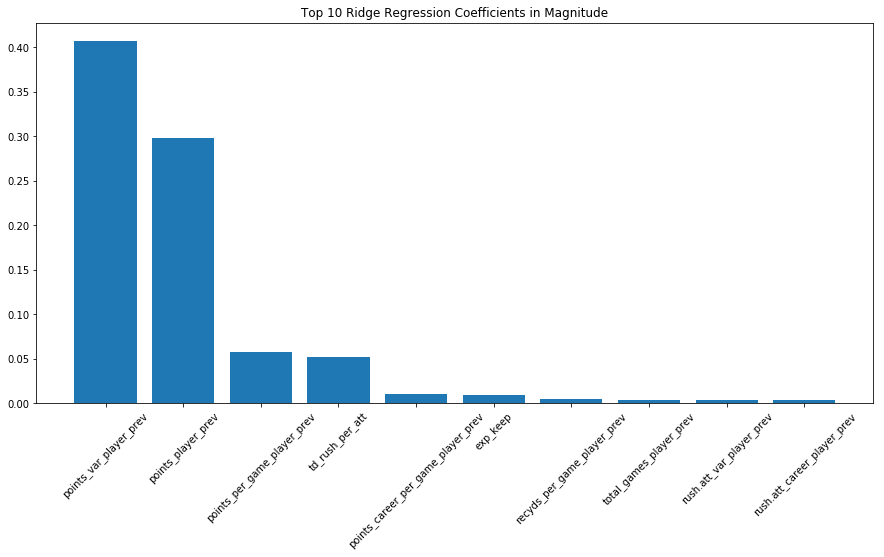

In [28]:
coefs = pd.DataFrame(coefs).head(10)

fig, axes = plt.subplots(1,1, figsize = (15,7))

axes.bar(x = coefs[1], height =  coefs[2])
axes.set_title('Top 10 Ridge Regression Coefficients in Magnitude')
axes.set_xticklabels(coefs[1],rotation=45);